In [1]:
from keras.layers import Conv2D , MaxPool2D ,ZeroPadding2D , UpSampling2D ,Reshape, Input ,Dense, Activation,Flatten
from keras.utils import np_utils
from keras.models import Model

In [2]:
e = 30

inp = Input(shape = (28,28,3))
conv1 = Conv2D(32 , (3,3) , activation = "relu")(inp)
conv2 = Conv2D(16 , (3,3),activation="relu")(conv1)
mp1 = MaxPool2D((2,2))(conv2)
conv3 = Conv2D(8,(3,3),activation="relu")(mp1)

flat = Flatten()(conv3)
emb = Dense(e , activation="sigmoid")(flat)
fc1 = Dense(800 , activation="sigmoid")(emb)

res1 = Reshape((10 , 10, 8))(fc1)
zrp1 = ZeroPadding2D((1,1))(res1)

conv4 = Conv2D(16 , (3,3),padding="same" , activation ="relu")(zrp1)
ups1 = UpSampling2D((2,2))(conv4)

zrp2 = ZeroPadding2D((1,1))(ups1)
conv5 = Conv2D(32,(3,3),padding="same" , activation ="relu")(zrp2)

zrp3 = ZeroPadding2D((1,1))(conv5)
conv6 = Conv2D(3,(3,3),padding="same" , activation="relu")(zrp3)

In [3]:
c_a_e = Model(inputs=inp, outputs=conv6)
c_a_e.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        4624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                

In [4]:
c_a_e.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [5]:
for i in enumerate(c_a_e.layers):
    print(i)

(0, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f529243dbe0>)
(1, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f529243db50>)
(2, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f52923c3e20>)
(3, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f52f0249790>)
(4, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f52923e2ca0>)
(5, <tensorflow.python.keras.layers.core.Flatten object at 0x7f52923e2070>)
(6, <tensorflow.python.keras.layers.core.Dense object at 0x7f5291bbaaf0>)
(7, <tensorflow.python.keras.layers.core.Dense object at 0x7f5290120880>)
(8, <tensorflow.python.keras.layers.core.Reshape object at 0x7f5290120c70>)
(9, <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f52901289d0>)
(10, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5290128f10>)
(11, <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x7f5290138ca0>)
(12, <tenso

In [6]:
encoder = Model(inputs=inp,outputs=emb)
encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        4624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                

In [7]:
decoder_input = Input(shape=(e,))
dec_layer = c_a_e.layers[7](decoder_input)

for i in range(8, len(c_a_e.layers)):
    dec_layer = c_a_e.layers[i](dec_layer)
decoder = Model(inputs=decoder_input, outputs=dec_layer)
decoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 800)               3200      
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 8)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 16)        1168      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 26, 26, 16)       

In [18]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping 
from keras.models import load_model

In [19]:
dataset = pd.read_csv("./main_dataset.csv")

In [10]:
dataset.head(5)

,Unnamed: 0,age,gender,race,image
0,0,3,0,0,training_real/real_00802.jpg
1,1,3,0,1,training_real/real_01004.jpg
2,2,4,0,0,training_real/real_01003.jpg
3,3,4,1,0,training_real/real_00739.jpg
4,4,4,1,1,training_real/real_00677.jpg


In [11]:
def training_dataset_(
    file_path,
    image_per_batch,
    start_row,
    ):
    df = pd.read_csv(file_path)[start_row:start_row+image_per_batch]
    
    df = df.drop('Unnamed: 0',axis=1)
    df = df.drop('age',axis=1)

    y = get_data_from_local(df)
    x = df.drop('image',axis=1)
    
    x = x.astype('float64')
    
    return x.values , y

In [12]:
def get_data_from_local(X_train):
    X_data =[]
    for file in tqdm(X_train['image']):
        file = file.replace('age_detection','dataset-code')
#         print(file)
        face = cv2.imread(file,cv2.IMREAD_COLOR)
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face =cv2.resize(face, (28,28))
#         face = np.expand_dims(face, axis=2)
        face = np.asarray(face)
        face = face.astype('float32')
        face /= 255
        X_data.append(face)
    return np.array(X_data)

In [14]:
def training(
    start_row,
    number_of_labels,
    file_path,
    image_per_batch,
    max_limit,
    path_of_model
):

    checkpoint = ModelCheckpoint(filepath=path_of_model,
                             monitor='val_accuracy',
                             save_format='tf',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )
    early_stopping_monitor = EarlyStopping(patience=2,verbose=1) 
    
    for x in range(start_row,max_limit,image_per_batch):
        
        print()
        print('**********{} -- {} out of {}************'.format(x,x+image_per_batch,max_limit))
        print()
    
        X_train , y_train   =   training_dataset_(
                        file_path = file_path,
                        start_row = 0,
                        image_per_batch = image_per_batch
        )
            
        F_mnist = c_a_e.fit(y_train[:800], y_train[:800],
                            shuffle=True,
                            epochs=30,
                            validation_data=(y_train[800:], y_train[800:]),
                            batch_size=64,
                            callbacks=[checkpoint,early_stopping_monitor]
       )


In [20]:
training(
    start_row = 0,
    number_of_labels = 3,
    file_path = '../facial_prediction/dataset_200.csv',
    image_per_batch = 1000,
    max_limit = 20000,
    path_of_model = 'final1_cnn_checkpoint.tf'
)

 13%|█▎        | 126/1000 [00:00<00:00, 1252.15it/s]


**********0 -- 1000 out of 20000************



100%|██████████| 1000/1000 [00:00<00:00, 1429.88it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.6504
Epoch 00001: val_accuracy improved from -inf to 0.57964, saving model to final1_cnn_checkpoint.tf
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: final1_cnn_checkpoint.tf/assets
13/13 [==============================] - 4s 290ms/step - loss: 0.1641 - accuracy: 0.6504 - val_loss: 0.1042 - val_accuracy: 0.5796
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.5555
Epoch 00002: val_accuracy improved from 0.57964 to 0.76195, saving model to final1_cnn_checkpoint.tf
INFO:tensorflow:Assets written to: final1_cnn_checkpoint.tf/assets
13/13 [==============================] - 4s 270ms/step - loss: 0.0867 - accuracy: 0.5555 - val_loss: 0.0768 - val_

 15%|█▍        | 146/1000 [00:00<00:00, 1455.76it/s]

Epoch 00017: early stopping

**********1000 -- 2000 out of 20000************



100%|██████████| 1000/1000 [00:00<00:00, 1604.53it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9265
Epoch 00001: val_accuracy did not improve from 0.92117
13/13 [==============================] - 2s 139ms/step - loss: 0.0497 - accuracy: 0.9265 - val_loss: 0.0538 - val_accuracy: 0.9212
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9267
Epoch 00002: val_accuracy improved from 0.92117 to 0.92370, saving model to final1_cnn_checkpoint.tf
INFO:tensorflow:Assets written to: final1_cnn_checkpoint.tf/assets
13/13 [==============================] - 3s 242ms/step - loss: 0.0498 - accuracy: 0.9267 - val_loss: 0.0527 - val_accuracy: 0.9237
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9287
Epoch 00003: val_accuracy did not improve from 0.92370
13/13 [==============================] - 2s 130ms/step - loss: 0.0495 - accuracy: 0.9287 - val_loss: 0.0524 - val_accuracy: 0.9237
Epoch 4/30
13/13 [=============================

 11%|█         | 109/1000 [00:00<00:00, 1089.65it/s]

Epoch 00006: early stopping

**********2000 -- 3000 out of 20000************



100%|██████████| 1000/1000 [00:00<00:00, 1541.11it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9297
Epoch 00001: val_accuracy did not improve from 0.92448
13/13 [==============================] - 2s 129ms/step - loss: 0.0494 - accuracy: 0.9297 - val_loss: 0.0526 - val_accuracy: 0.9245
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9301
Epoch 00002: val_accuracy improved from 0.92448 to 0.92522, saving model to final1_cnn_checkpoint.tf
INFO:tensorflow:Assets written to: final1_cnn_checkpoint.tf/assets
13/13 [==============================] - 3s 260ms/step - loss: 0.0494 - accuracy: 0.9301 - val_loss: 0.0522 - val_accuracy: 0.9252
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9299
Epoch 00003: val_accuracy did not improve from 0.92522
13/13 [==============================] - 2s 125ms/step - loss: 0.0496 - accuracy: 0.9299 - val_loss: 0.0525 - val_accuracy: 0.9252
Epoch 4/30
13/13 [=============================

100%|██████████| 1000/1000 [00:00<00:00, 1568.19it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.9314
Epoch 00001: val_accuracy improved from 0.92599 to 0.92667, saving model to final1_cnn_checkpoint.tf
INFO:tensorflow:Assets written to: final1_cnn_checkpoint.tf/assets
13/13 [==============================] - 3s 269ms/step - loss: 0.0492 - accuracy: 0.9314 - val_loss: 0.0520 - val_accuracy: 0.9267
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9318
Epoch 00002: val_accuracy did not improve from 0.92667
13/13 [==============================] - 2s 147ms/step - loss: 0.0490 - accuracy: 0.9318 - val_loss: 0.0523 - val_accuracy: 0.9267
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9318
Epoch 00003: val_accuracy did not improve from 0.92667
13/13 [==============================] - 2s 127ms/step - loss: 0.0491 - accuracy: 0.9318 - val_loss: 0.0525 - val_accuracy: 0.9267
Epoch 00003: early stopping

**********4000 -- 

100%|██████████| 1000/1000 [00:00<00:00, 1783.80it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9319
Epoch 00001: val_accuracy improved from 0.92667 to 0.92716, saving model to final1_cnn_checkpoint.tf
INFO:tensorflow:Assets written to: final1_cnn_checkpoint.tf/assets
13/13 [==============================] - 3s 230ms/step - loss: 0.0491 - accuracy: 0.9319 - val_loss: 0.0522 - val_accuracy: 0.9272
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9319
Epoch 00002: val_accuracy did not improve from 0.92716
13/13 [==============================] - 2s 125ms/step - loss: 0.0488 - accuracy: 0.9319 - val_loss: 0.0516 - val_accuracy: 0.9272
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9324
Epoch 00003: val_accuracy did not improve from 0.92716
13/13 [==============================] - 2s 123ms/step - loss: 0.0489 - accuracy: 0.9324 - val_loss: 0.0516 - val_accuracy: 0.9272
Epoch 4/30
13/13 [=============================

Epoch 28/30
13/13 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9332
Epoch 00028: val_accuracy improved from 0.92786 to 0.92790, saving model to final1_cnn_checkpoint.tf
INFO:tensorflow:Assets written to: final1_cnn_checkpoint.tf/assets
13/13 [==============================] - 3s 232ms/step - loss: 0.0323 - accuracy: 0.9332 - val_loss: 0.0349 - val_accuracy: 0.9279
Epoch 29/30
13/13 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9332
Epoch 00029: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 127ms/step - loss: 0.0320 - accuracy: 0.9332 - val_loss: 0.0345 - val_accuracy: 0.9279
Epoch 30/30
13/13 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.9332
Epoch 00030: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 137ms/step - loss: 0.0315 - accuracy: 0.9332 - val_loss: 0.0345 - val_accuracy: 0.9279

**********5000 -- 6000 out of 20000********

100%|██████████| 1000/1000 [00:00<00:00, 1657.36it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9332
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 144ms/step - loss: 0.0311 - accuracy: 0.9332 - val_loss: 0.0335 - val_accuracy: 0.9279
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9332
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 152ms/step - loss: 0.0305 - accuracy: 0.9332 - val_loss: 0.0333 - val_accuracy: 0.9279
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.9332
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 134ms/step - loss: 0.0301 - accuracy: 0.9332 - val_loss: 0.0326 - val_accuracy: 0.9278
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9332
Epoch 00004: val_accuracy did not improve from 0.92790
13/13 [====

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00026: early stopping

**********6000 -- 7000 out of 20000************



100%|██████████| 1000/1000 [00:00<00:00, 1557.33it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9332
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 124ms/step - loss: 0.0254 - accuracy: 0.9332 - val_loss: 0.0272 - val_accuracy: 0.9279
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9332
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 119ms/step - loss: 0.0252 - accuracy: 0.9332 - val_loss: 0.0273 - val_accuracy: 0.9279
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.9332
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 124ms/step - loss: 0.0253 - accuracy: 0.9332 - val_loss: 0.0269 - val_accuracy: 0.9279
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9332
Epoch 00004: val_accuracy did not improve from 0.92790
13/13 [====

100%|██████████| 1000/1000 [00:00<00:00, 1552.23it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9332
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 145ms/step - loss: 0.0249 - accuracy: 0.9332 - val_loss: 0.0268 - val_accuracy: 0.9279
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9332
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 145ms/step - loss: 0.0250 - accuracy: 0.9332 - val_loss: 0.0267 - val_accuracy: 0.9279
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9332
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 128ms/step - loss: 0.0249 - accuracy: 0.9332 - val_loss: 0.0266 - val_accuracy: 0.9279
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9332
Epoch 00004: val_accuracy did not improve from 0.92790
13/13 [====

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00007: early stopping

**********8000 -- 9000 out of 20000************



100%|██████████| 1000/1000 [00:00<00:00, 1583.42it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9332
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 148ms/step - loss: 0.0249 - accuracy: 0.9332 - val_loss: 0.0266 - val_accuracy: 0.9279
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9332
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 139ms/step - loss: 0.0249 - accuracy: 0.9332 - val_loss: 0.0267 - val_accuracy: 0.9279
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9332
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 125ms/step - loss: 0.0249 - accuracy: 0.9332 - val_loss: 0.0265 - val_accuracy: 0.9279
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9332
Epoch 00004: val_accuracy did not improve from 0.92790
13/13 [====

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00005: early stopping

**********9000 -- 10000 out of 20000************



100%|██████████| 1000/1000 [00:00<00:00, 1064.46it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9332
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 3s 224ms/step - loss: 0.0248 - accuracy: 0.9332 - val_loss: 0.0265 - val_accuracy: 0.9279
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9332
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 3s 232ms/step - loss: 0.0247 - accuracy: 0.9332 - val_loss: 0.0264 - val_accuracy: 0.9279
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9332
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 3s 221ms/step - loss: 0.0248 - accuracy: 0.9332 - val_loss: 0.0269 - val_accuracy: 0.9279
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9332
Epoch 00004: val_accuracy did not improve from 0.92790
13/13 [====

100%|██████████| 1000/1000 [00:00<00:00, 1062.68it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9332
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 3s 225ms/step - loss: 0.0249 - accuracy: 0.9332 - val_loss: 0.0269 - val_accuracy: 0.9279
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9332
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 3s 214ms/step - loss: 0.0248 - accuracy: 0.9332 - val_loss: 0.0263 - val_accuracy: 0.9279
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9332
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 3s 209ms/step - loss: 0.0247 - accuracy: 0.9332 - val_loss: 0.0265 - val_accuracy: 0.9279
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9332
Epoch 00004: val_accuracy did not improve from 0.92790
13/13 [====

 14%|█▍        | 138/1000 [00:00<00:00, 1370.36it/s]

Epoch 00006: early stopping

**********11000 -- 12000 out of 20000************



100%|██████████| 1000/1000 [00:00<00:00, 1371.15it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9332
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 188ms/step - loss: 0.0247 - accuracy: 0.9332 - val_loss: 0.0266 - val_accuracy: 0.9279
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9332
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 149ms/step - loss: 0.0247 - accuracy: 0.9332 - val_loss: 0.0264 - val_accuracy: 0.9279
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9332
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 3s 208ms/step - loss: 0.0248 - accuracy: 0.9332 - val_loss: 0.0265 - val_accuracy: 0.9278
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9332
Epoch 00004: val_accuracy did not improve from 0.92790
13/13 [====

100%|██████████| 1000/1000 [00:00<00:00, 1424.17it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9332
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 147ms/step - loss: 0.0246 - accuracy: 0.9332 - val_loss: 0.0262 - val_accuracy: 0.9278
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9331
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 161ms/step - loss: 0.0245 - accuracy: 0.9331 - val_loss: 0.0262 - val_accuracy: 0.9279
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9332
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 151ms/step - loss: 0.0246 - accuracy: 0.9332 - val_loss: 0.0267 - val_accuracy: 0.9279
Epoch 00003: early stopping

**********13000 -- 14000 out of 20000************



100%|██████████| 1000/1000 [00:00<00:00, 1488.48it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9332
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 132ms/step - loss: 0.0247 - accuracy: 0.9332 - val_loss: 0.0263 - val_accuracy: 0.9278
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9332
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 139ms/step - loss: 0.0245 - accuracy: 0.9332 - val_loss: 0.0262 - val_accuracy: 0.9279
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9331
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 136ms/step - loss: 0.0245 - accuracy: 0.9331 - val_loss: 0.0264 - val_accuracy: 0.9278
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9331
Epoch 00004: val_accuracy did not improve from 0.92790
13/13 [====

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00004: early stopping

**********14000 -- 15000 out of 20000************



100%|██████████| 1000/1000 [00:00<00:00, 1474.71it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9331
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 135ms/step - loss: 0.0245 - accuracy: 0.9331 - val_loss: 0.0263 - val_accuracy: 0.9278
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9331
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 141ms/step - loss: 0.0244 - accuracy: 0.9331 - val_loss: 0.0262 - val_accuracy: 0.9279
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9331
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 131ms/step - loss: 0.0245 - accuracy: 0.9331 - val_loss: 0.0262 - val_accuracy: 0.9278
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9331
Epoch 00004: val_accuracy did not improve from 0.92790
13/13 [====

100%|██████████| 1000/1000 [00:00<00:00, 1373.85it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9331
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 143ms/step - loss: 0.0244 - accuracy: 0.9331 - val_loss: 0.0262 - val_accuracy: 0.9277
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9331
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 160ms/step - loss: 0.0244 - accuracy: 0.9331 - val_loss: 0.0262 - val_accuracy: 0.9277
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9331
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 147ms/step - loss: 0.0245 - accuracy: 0.9331 - val_loss: 0.0261 - val_accuracy: 0.9277
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9331
Epoch 00004: val_accuracy did not improve from 0.92790
13/13 [====

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00007: early stopping

**********16000 -- 17000 out of 20000************



100%|██████████| 1000/1000 [00:00<00:00, 1391.82it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9331
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 150ms/step - loss: 0.0243 - accuracy: 0.9331 - val_loss: 0.0260 - val_accuracy: 0.9278
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9331
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 156ms/step - loss: 0.0243 - accuracy: 0.9331 - val_loss: 0.0261 - val_accuracy: 0.9278
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9331
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 153ms/step - loss: 0.0244 - accuracy: 0.9331 - val_loss: 0.0261 - val_accuracy: 0.9278


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00003: early stopping

**********17000 -- 18000 out of 20000************



100%|██████████| 1000/1000 [00:00<00:00, 1349.40it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9331
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 130ms/step - loss: 0.0244 - accuracy: 0.9331 - val_loss: 0.0263 - val_accuracy: 0.9278
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9331
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 148ms/step - loss: 0.0245 - accuracy: 0.9331 - val_loss: 0.0262 - val_accuracy: 0.9278
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9331
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 138ms/step - loss: 0.0244 - accuracy: 0.9331 - val_loss: 0.0261 - val_accuracy: 0.9278
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9330
Epoch 00004: val_accuracy did not improve from 0.92790
13/13 [====

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00005: early stopping

**********18000 -- 19000 out of 20000************



100%|██████████| 1000/1000 [00:00<00:00, 1629.17it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9330
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 132ms/step - loss: 0.0243 - accuracy: 0.9330 - val_loss: 0.0261 - val_accuracy: 0.9278
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9330
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 139ms/step - loss: 0.0243 - accuracy: 0.9330 - val_loss: 0.0261 - val_accuracy: 0.9278
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9331
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 145ms/step - loss: 0.0243 - accuracy: 0.9331 - val_loss: 0.0260 - val_accuracy: 0.9277
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9330
Epoch 00004: val_accuracy did not improve from 0.92790
13/13 [====

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00005: early stopping

**********19000 -- 20000 out of 20000************



100%|██████████| 1000/1000 [00:00<00:00, 1498.95it/s]


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9329
Epoch 00001: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 140ms/step - loss: 0.0243 - accuracy: 0.9329 - val_loss: 0.0260 - val_accuracy: 0.9276
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9330
Epoch 00002: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 136ms/step - loss: 0.0243 - accuracy: 0.9330 - val_loss: 0.0260 - val_accuracy: 0.9277
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9329
Epoch 00003: val_accuracy did not improve from 0.92790
13/13 [==============================] - 2s 139ms/step - loss: 0.0242 - accuracy: 0.9329 - val_loss: 0.0262 - val_accuracy: 0.9277
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9330
Epoch 00004: val_accuracy did not improve from 0.92790
13/13 [====

In [23]:
X_train , y_train   =   training_dataset_(
                        file_path = '../facial_prediction/dataset_200.csv',
                        start_row = 0,
                        image_per_batch = 1000
        )

100%|██████████| 1000/1000 [00:00<00:00, 1596.62it/s]


In [24]:
test = y_train[950:]
preds = c_a_e.predict(test)
print(test.shape, preds.shape)

(50, 28, 28, 3) (50, 28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<ipython-input-25-ee65195a5739>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


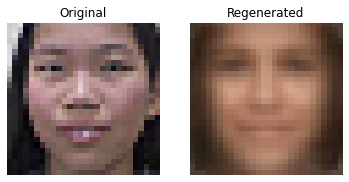

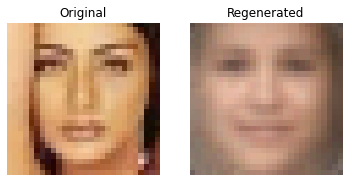

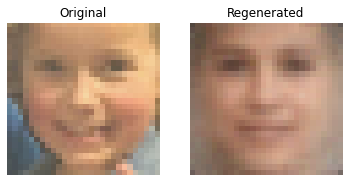

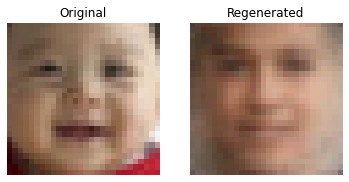

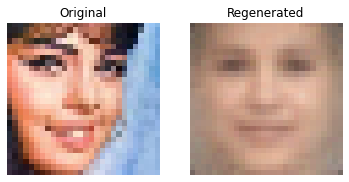

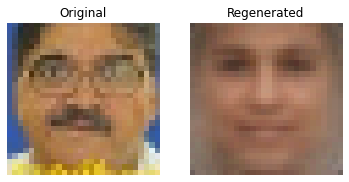

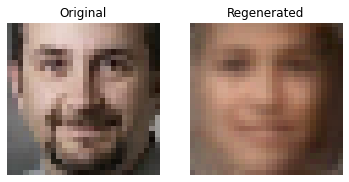

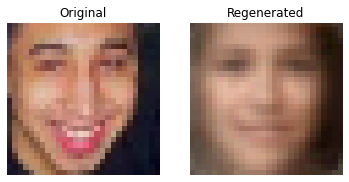

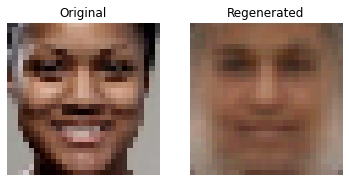

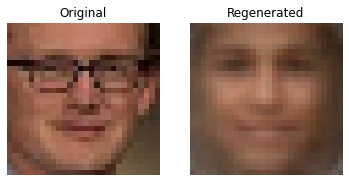

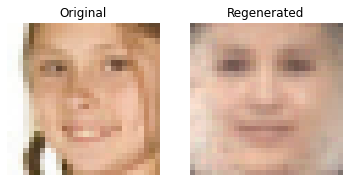

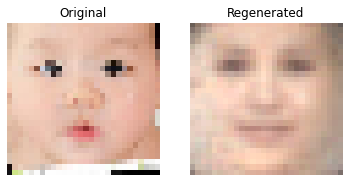

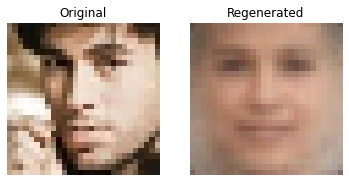

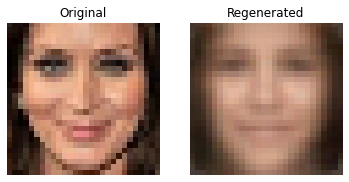

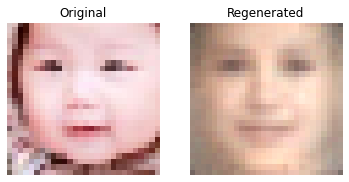

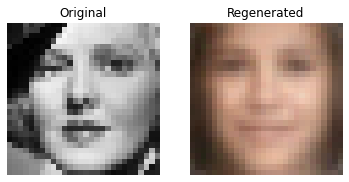

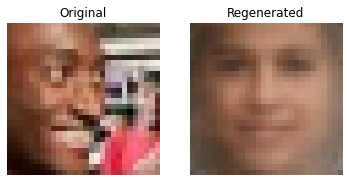

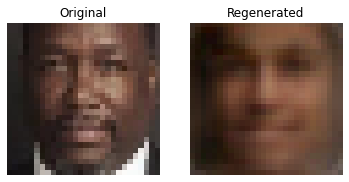

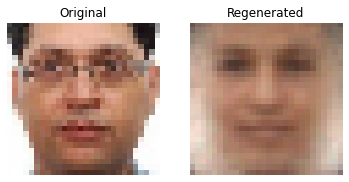

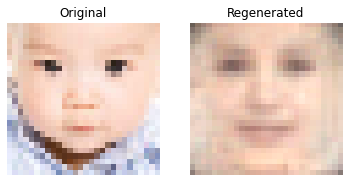

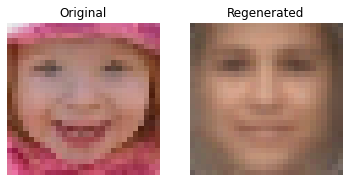

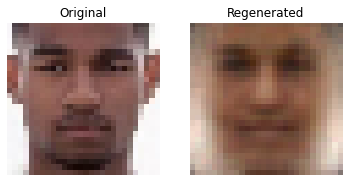

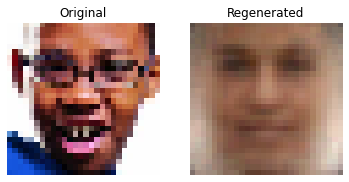

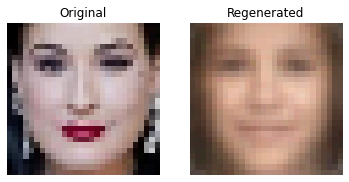

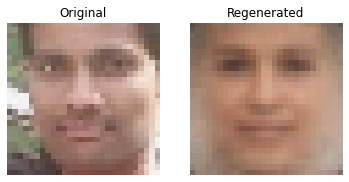

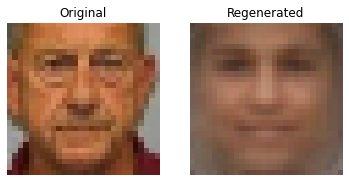

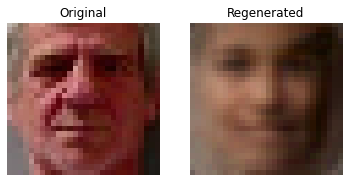

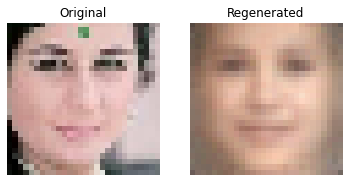

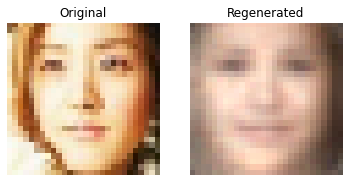

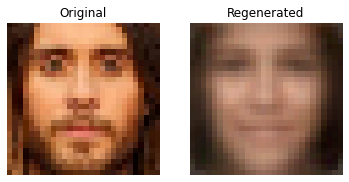

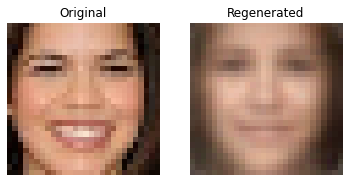

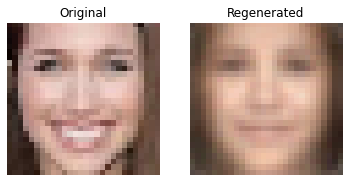

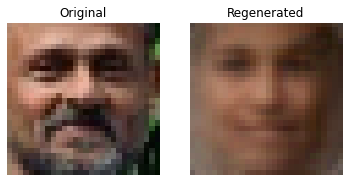

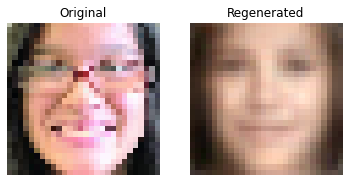

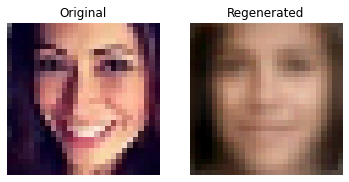

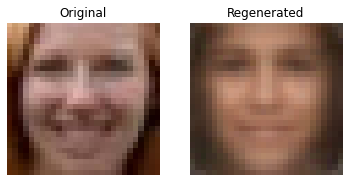

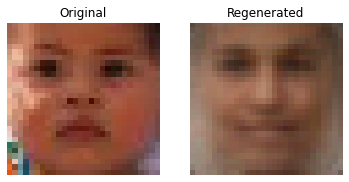

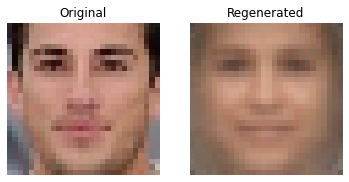

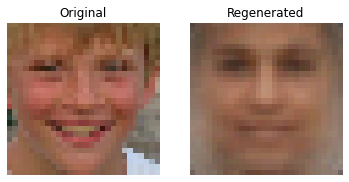

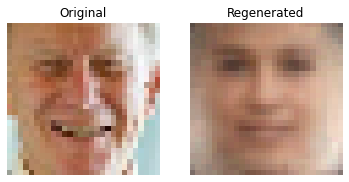

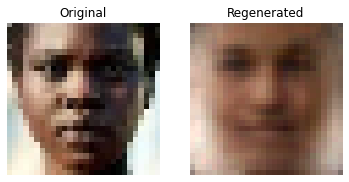

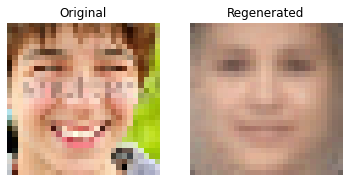

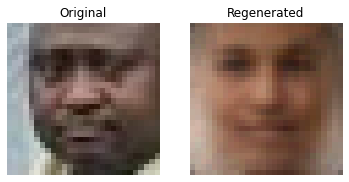

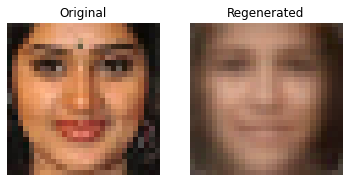

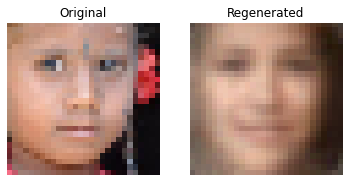

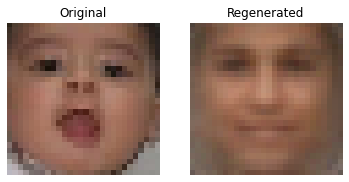

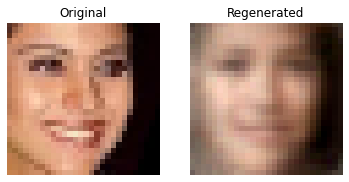

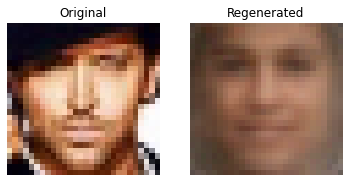

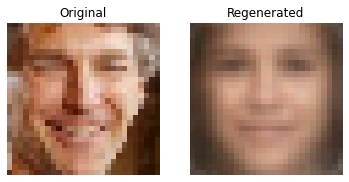

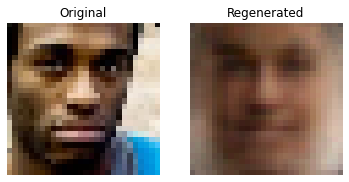

In [25]:
for i in range(test.shape[0]):
    plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(test[i])
    
    plt.subplot(1,2,2)
    plt.title('Regenerated')
    plt.axis('off')
    plt.imshow(preds[i])
